<a href="https://colab.research.google.com/github/MthabisiPatrice/Machine-Learning-/blob/main/notebooks/starter_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Shift the image horizontally by up to 20% of the width
    height_shift_range=0.2,     # Shift the image vertically by up to 20% of the height
    shear_range=0.2,            # Shear angle in counter-clockwise direction
    zoom_range=0.2,             # Randomly zoom inside pictures
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest',        # Fill in newly created pixels after transformations
    validation_split=0.2,       # Keep 20% of the images for validation
    brightness_range=(0.5, 1.5),  # Brightness adjustments from 50% to 150%
)
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

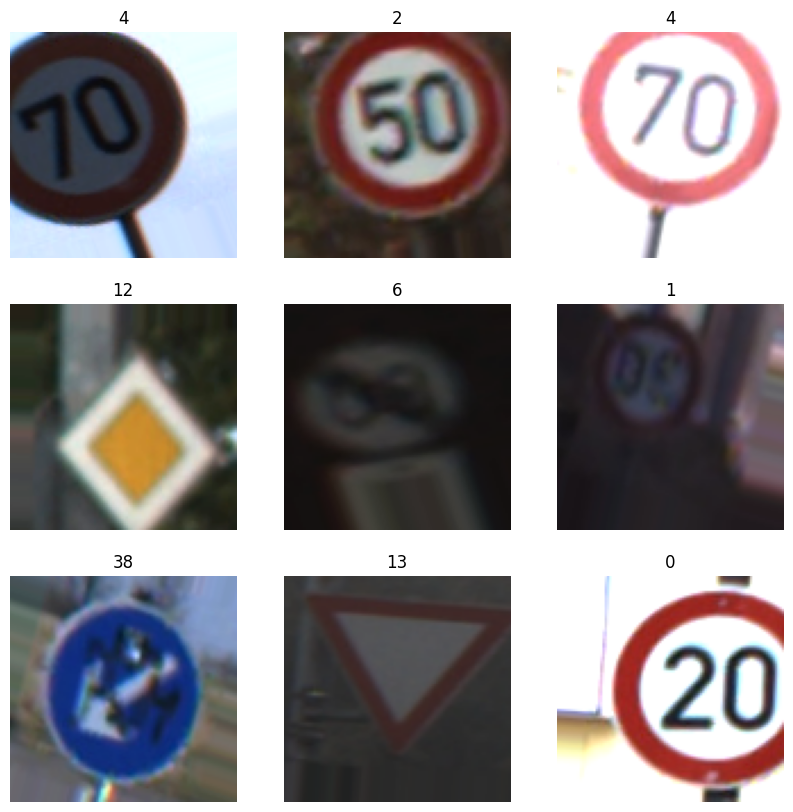

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [9]:
# Build a model...

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = models.Sequential()

# Convolutional layer 1
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Convolutional layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into a fully connected (Dense) layer
model.add(layers.Flatten())

# Dense layer with dropout and regularization to avoid overfitting
model.add(layers.Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.1))  # Dropout rate of 50%

# Output layer (number of classes should match your dataset)
model.add(layers.Dense(43, activation='softmax'))  # Adjust the 10 to your number of classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summarize the model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │      12,801,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          43,043 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,187 (49.36 MB)

 Trainable params: 12,937,739 (49.35 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
from google.colab import drive
drive.mount('/content/drive')


checkpoint_path = "/content/drive/MyDrive/model_checkpoints/checkpoint_{epoch:02d}.weights.h5"
checkpoint_dir = "/content/drive/MyDrive/model_checkpoints"

#checkpoint_filepath = '/tmp/checkpoint5.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor the validation loss
    factor=0.2,            # Reduce the learning rate by a factor of 0.2
    patience=5,            # Wait for 5 epochs to see improvement before reducing
    min_lr=1e-6            # Set a lower bound for the learning rate
)

# Create an instance of EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10) # You can customize the parameters

# Now you can pass it to the callbacks list
history = model.fit(
    train_generator,
    #steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Set the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint_callback, reduce_lr]  # Include reduce_lr here
)

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 150s 152ms/step - accuracy: 0.4265 - loss: 3.0583 - val_accuracy: 0.6389 - val_loss: 2.0128 - learning_rate: 2.0000e-04
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 197s 147ms/step - accuracy: 0.7414 - loss: 1.5709 - val_accuracy: 0.0000e+00 - val_loss: 2.2156 - learning_rate: 2.0000e-04
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


981/981 ━━━━━━━━━━━━━━━━━━━━ 148s 149ms/step - accuracy: 0.8116 - loss: 1.2341 - val_accuracy: 0.7450 - val_loss: 1.4508 - learning_rate: 2.0000e-04
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 143s 145ms/step - accuracy: 0.8495 - loss: 1.0476 - val_accuracy: 1.0000 - val_loss: 0.5536 - learning_rate: 2.0000e-04
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 206s 149ms/step - accuracy: 0.8748 - loss: 0.9176 - val_accuracy: 0.7875 - val_loss: 1.2083 - learning_rate: 2.0000e-04
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 139s 141ms/step - accuracy: 0.8934 - loss: 0.8269 - val_accuracy: 1.0000 - val_loss: 0.4912 - learning_rate: 2.0000e-04
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 146s 146ms/step - accuracy: 0.9064 - loss: 0.7682 - val_accuracy: 0.7943 - val_loss: 1.1555 - learning_rate: 2.0000e-04
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - accuracy: 0.9169 - loss: 0.7186 - val_accuracy: 1.0000 - val_loss: 0.4566 - learning_rate: 2.0000e-04
Epoch 9/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 146s 144ms/

In [23]:
model.save_weights(checkpoint_path)

In [24]:
# Assuming your last epoch was 10
epoch_number = 10 # Replace with the epoch number you want to load
checkpoint_path = f"/content/drive/MyDrive/model_checkpoints/checkpoint_{epoch_number:02d}.weights.h5"
model.load_weights(checkpoint_path)

In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
print(predictions)
actual_mini = pd.read_csv('/content/mini_holdout_answers.csv')
print(actual_mini)
(actual_mini.ClassId==predictions).mean()

Found 201 images belonging to 1 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[16, 1, 38, 35, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 19, 27, 38, 4, 33, 9, 3, 1, 11, 13, 10, 9, 11, 5, 17, 34, 23, 2, 8, 3, 12, 16, 5, 7, 30, 18, 12, 24, 25, 3, 10, 18, 8, 38, 13, 15, 9, 13, 34, 5, 26, 9, 16, 38, 10, 4, 9, 15, 9, 26, 2, 5, 28, 11, 25, 30, 34, 5, 12, 2, 10, 25, 25, 21, 34, 25, 8, 10, 35, 3, 7, 22, 13, 3, 1, 2, 14, 12, 32, 3, 38, 9, 33, 1, 10, 5, 11, 33, 4, 35, 25, 34, 4, 2, 14, 16, 10, 20, 3, 27, 29, 1, 17, 13, 7, 1, 8, 2, 10, 10, 20, 1, 6, 36, 1, 14, 13, 11, 10, 18, 34, 2, 38, 41, 4, 6, 18, 17, 36, 2, 41, 11, 21, 5, 24, 11, 25, 17, 3, 6, 9, 7, 1, 13, 16, 4, 28, 18, 9, 13, 14, 29, 17, 13, 38, 26, 30, 33, 1, 3, 34, 13, 2, 8, 4, 36, 25, 19, 25, 18, 1, 10, 8, 10, 29, 12, 38, 31, 2, 4, 38, 18, 24, 17]
      Filename  ClassId
0    00000.jpg       16
1    00001.jpg        1
2    00002.jpg       38
3    00003.jpg       33
4    00004.jpg       11
..         ...      ...
196  00196.jpg     

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


0.8805970149253731

Accuracy for class Speed_20: 1.0
Accuracy for class Speed_30: 0.9800995024875622
Accuracy for class Speed_50: 0.9900497512437811


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy for class Speed_60: 0.9950248756218906
Accuracy for class Speed_70: 0.9900497512437811
Accuracy for class Speed_80: 0.9900497512437811
Accuracy for class Speed_Limit_Ends: 1.0
Accuracy for class Speed_100: 0.9900497512437811
Accuracy for class Speed_120: 0.9800995024875622
Accuracy for class Overtaking_Prohibited: 1.0
Accuracy for class Overtakeing_Prohibited_Trucks: 1.0
Accuracy for class Crossroad_Ahead: 1.0
Accuracy for class Priority_Road_Ahead: 1.0
Accuracy for class Yield: 1.0
Accuracy for class STOP: 1.0
Accuracy for class Entry_Forbidden: 1.0
Accuracy for class Trucks_Forbidden: 1.0
Accuracy for class No_Entry(one-way traffic): 0.9950248756218906
Accuracy for class Cars_Prohibited(!): 1.0
Accuracy for class Left_Curve_Ahead: 0.9900497512437811
Accuracy for class Right_Curve_Ahead: 0.9800995024875622
Accuracy for class Bends_Left_Then_Right: 1.0
Accuracy for class Poor_Surface_Ahead: 1.0
Accuracy for class Slippery_Surface_Ahead: 1.0
Accuracy for class Road_Narrows_On_R

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy for class Passing_Right_Compulsory: 0.9950248756218906
Accuracy for class Passing_Left_Compulsory: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Accuracy for class Roundabout: 0.9900497512437811
Accuracy for class End_Overtaking_Prohibition: 1.0
Accuracy for class End_Overtaking_Prohibition_Trucks: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
<ipython-input-26-73f2e753dfe8>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=accuracies, palette="viridis")


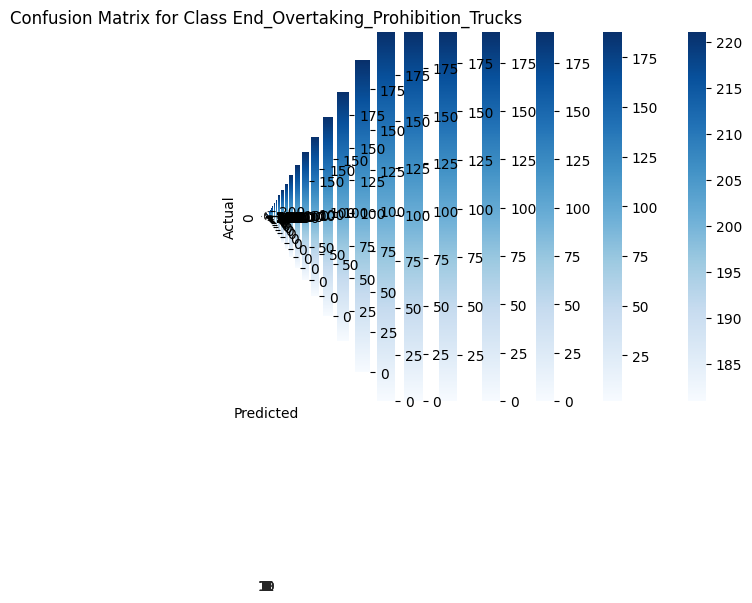

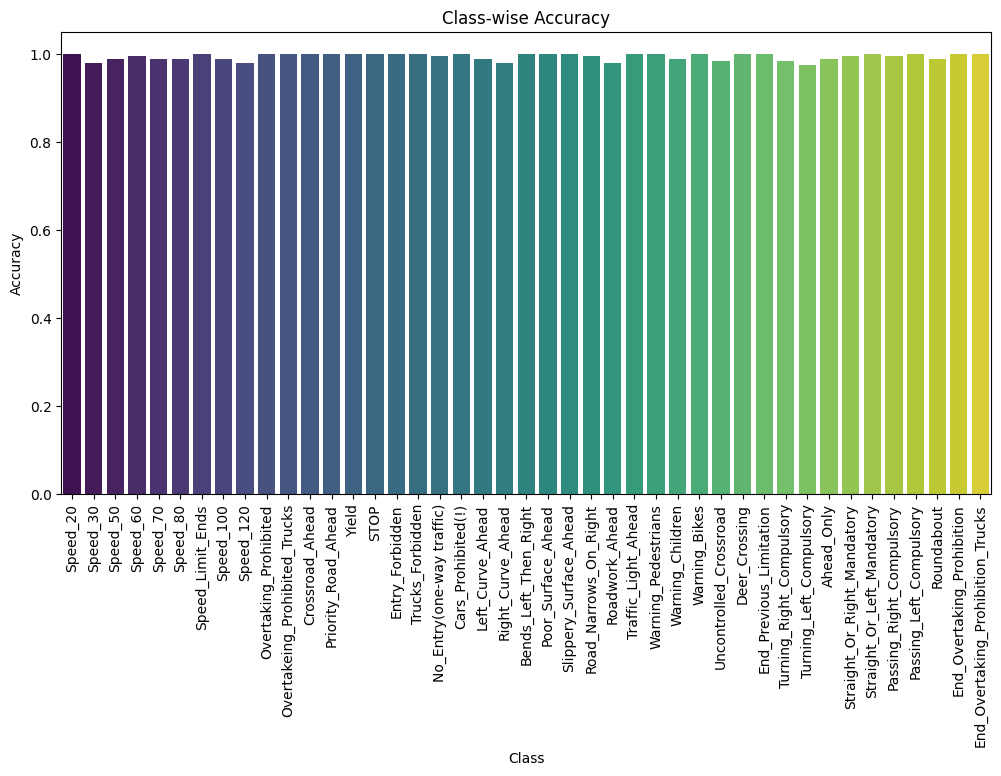

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

class_accuracy = {}

# Loop through each class to calculate accuracy and confusion matrix
for class_idx in range(43):
    class_name = target_names[class_idx]
    class_predictions = [1 if predictions[i] == class_idx else 0 for i in range(len(predictions))]
    class_actual = [1 if actual_mini.ClassId[i] == class_idx else 0 for i in range(len(actual_mini))]

    # Calculate accuracy for the class
    class_accuracy[class_name] = (np.array(class_predictions) == np.array(class_actual)).mean()
    print(f"Accuracy for class {class_name}: {class_accuracy[class_name]}")

    # Plot confusion matrix for the class
    fig = sns.heatmap(confusion_matrix(class_actual, class_predictions), annot=True, fmt='d', cmap='Blues')
    fig.set_xlabel('Predicted')
    fig.set_ylabel('Actual')
    fig.set_title(f'Confusion Matrix for Class {class_name}')
    #plt.show()

# Convert the class accuracy dictionary to lists of class names and accuracies
class_names = list(class_accuracy.keys())
accuracies = list(class_accuracy.values())

# Create a bar plot of the class-wise accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=accuracies, palette="viridis")
plt.xticks(rotation=90)  # Rotate class labels for better readability
plt.title("Class-wise Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()



In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```